Populating the interactive namespace from numpy and matplotlib


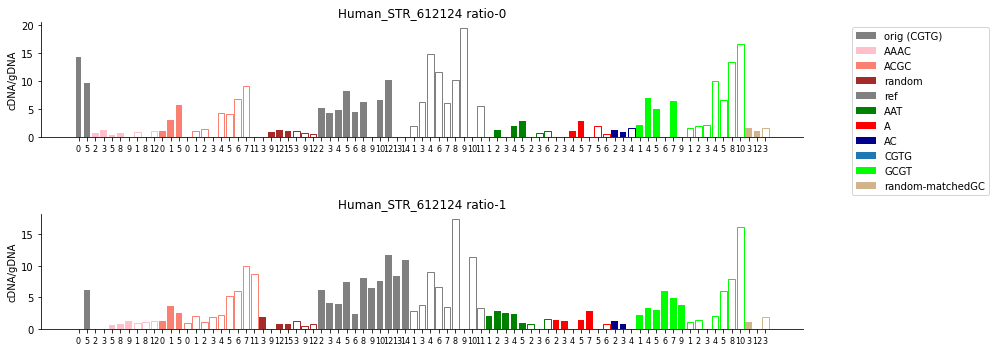

In [162]:
%pylab inline
import pandas as pd

#STRID = "Human_STR_658927"
#STRID = "Human_STR_886161"
STRID = "Human_STR_612124"

ORIGCOLOR = "grey"
ORIGWIDTH = 0.7
NAVAL = 0
MOTIF_COLORS = {
    "A": "red",
    'ACACGC': "plum",
    "AT": "orange",
    "AAAC": "pink",
    'AAAAC': "yellow",
    'AAAAAC': "wheat",
    "AC": "darkblue",
    "AAG": "olive",
    'GCGTGT': "khaki",
    "CG": "lavender",
    "CCG": "purple",
    "CGG": "violet",
    'CCCGG': "slateblue",
    'CCGGG': "mediumpurple",
    'CCCCG': "navy",
    'CGGGG': "midnightblue",
    'CGGGCT': "royalblue",
    'CGTGTG': "olivedrab",
    'AGCCCG': "cornflowerblue",
    "ACGCGC": "gold",
    "GCGCGT": "cyan",
    "AGAT": "darkred",
    "GGGCT": "cyan",
    "AGCCC": "salmon",
    "ACGC": "salmon",
    "AAT": "green",
    "CGTG": "green",
    "AGGGG": "deeppink",
    "CGGCT": "darkseagreen",
    'AGGCGG': "fuchsia",
    'GCGT': "lime",
    "AGCCG": "sienna",
    'CCGCCT': "indigo",
    "GTTTT": "bisque",
    'GTTT': "steelblue",
    'GTTTTT': "aquamarine",
    'CCCCT': "thistle",
    'AGC': "goldenrod",
    "random": "brown",
    "random-matchedGC": "tan",
    "ref": ORIGCOLOR
}

counts_files = [
    "rep2_count_matrix.csv",
    "rep3_count_matrix.csv"
]

count_dfs = [pd.read_csv(f) for f in counts_files]

def GetLen(key):
    if "p5" in key: return 5
    elif "m5" in key: return -5
    elif "p3" in key: return 3
    elif key.endswith("ref"): return 0
    else: return int(key.split("_")[4])
    
def GetMotif(key):
    if len(key.split("_"))==5:
        return key.split("_")[3]
    else: return key.split("_")[5]
    
def GetStrand(key):
    if len(key.split("_"))==5:
        return -1
    else:
        return int(key.split("_")[6].strip("*"))
    
def GetRepRatios(df, strid):
    cdna_col = [item for item in df.columns if item.startswith("cDNA")][0]
    gdna_col = [item for item in df.columns if item.startswith("gDNA")][0]

    dfcopy = df[(df["STR"].apply(lambda x: x.startswith(strid))) & 
           (df[gdna_col]>=10)].copy()
    dfcopy["ratio" ] = dfcopy.apply(lambda x: x[cdna_col]/x[gdna_col], 1)

    dfmerge = dfcopy.groupby("STR", as_index=False).agg({"ratio": np.median})
    dfmerge = dfmerge.rename(columns={"ratio": "ratio.median"})
    return dict(zip(dfmerge["STR"], dfmerge["ratio.median"]))

def MergeKeys(allratios):
    allkeys = []
    for ar in allratios:
        allkeys.extend(ar.keys())
    keyset = pd.DataFrame({"key": list(set(allkeys))})

    keyset["len"] = keyset["key"].apply(lambda x: GetLen(x), 1)
    keyset["motif"] = keyset["key"].apply(lambda x: GetMotif(x), 1)
    keyset["strand"] = keyset["key"].apply(lambda x: GetStrand(x), 1)
    keyset["is.orig"] = keyset["key"].apply(lambda x: len(x.split("_"))==5, 1)
    keyset["is.ref"] = keyset["key"].apply(lambda x: x.endswith("*"), 1)
    keyset = keyset.sort_values(["is.orig","motif","len","strand"])
    return keyset
    
def GetUberRatios(count_dfs, strid):
    allratios = [GetRepRatios(df, strid) for df in count_dfs]
    keyset = MergeKeys(allratios)
    for i in range(len(count_dfs)):
        ratios = [allratios[i].get(k, NAVAL) for k in keyset["key"].values]
        keyset["ratio-%s"%i] = ratios
    return keyset
    
def PlotUberRep(ax, ratiodata, ratcol, legend=False):
    labels = []
    numx = 0
    # First plot orig sequences
    orig = ratiodata[ratiodata["is.orig"]]
    if orig.shape[0] > 0:
        ax.bar(range(orig.shape[0]), orig[ratcol], color=ORIGCOLOR, width=ORIGWIDTH, label="orig (%s)"%orig["motif"].values[0])
        labels.extend(list(orig["len"].values))
        numx = orig.shape[0]
    # Now plot other motifs (by strand)
    motifs = set(ratiodata["motif"])
    for m in motifs:
        # Strand=0
        mdata = ratiodata[(ratiodata["motif"]==m) & (ratiodata["strand"]==0)]
        ax.bar(range(numx, mdata.shape[0]+numx), mdata[ratcol], color=MOTIF_COLORS[m], label=m)
        labels.extend(list(mdata["len"].values))
        numx += mdata.shape[0]
        # Strand=1
        mdata = ratiodata[(ratiodata["motif"]==m) & (ratiodata["strand"]==1)]
        ax.bar(range(numx, mdata.shape[0]+numx), mdata[ratcol], edgecolor=MOTIF_COLORS[m], color="white")
        labels.extend(list(mdata["len"].values))
        numx += mdata.shape[0]
    ax.set_xticks(range(numx))
    ax.set_xticklabels(labels, size=8)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylabel("cDNA/gDNA")
    if legend: ax.legend(bbox_to_anchor=(1.25, 1.0), loc='upper right')

def PlotUber(count_dfs, strid, fname=None):
    # Get ratios for each rep
    ratiodata = GetUberRatios(count_dfs, strid)
    
    # Make plot
    numplots = len(count_dfs)
    fig = plt.figure()
    fig.set_size_inches((14, 5))
    for i in range(len(count_dfs)):
        ax = fig.add_subplot(numplots, 1, i+1)
        PlotUberRep(ax, ratiodata, "ratio-%s"%i, legend=(i==0))
        ax.set_title("%s %s"%(strid, "ratio-%s"%i))
    fig.tight_layout()
    if fname is not None: fig.savefig(fname)

PlotUber(count_dfs, STRID)

Human_STR_916746
Human_STR_608555
Human_STR_1199914
Human_STR_780041
Human_STR_890634
Human_STR_1319870
Human_STR_569710
Human_STR_65623
Human_STR_279412
Human_STR_570870
Human_STR_162936
Human_STR_490362
Human_STR_925031
Human_STR_1500675
Human_STR_818848
Human_STR_1019944
Human_STR_702404
Human_STR_441841
Human_STR_13314
Human_STR_728459


KeyError: 'ACACGC'

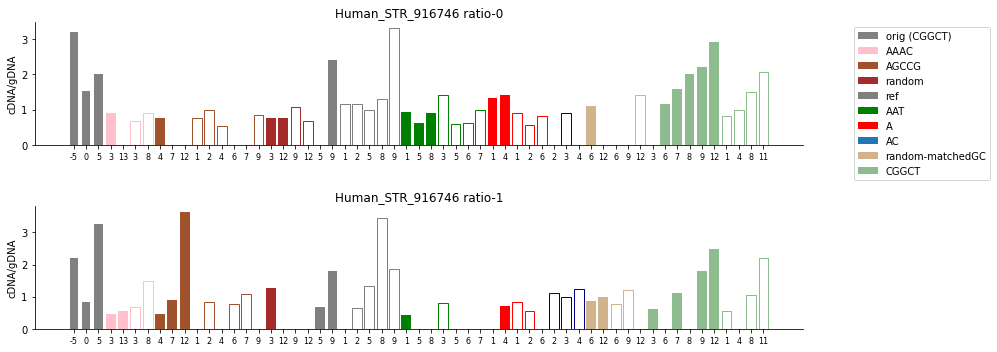

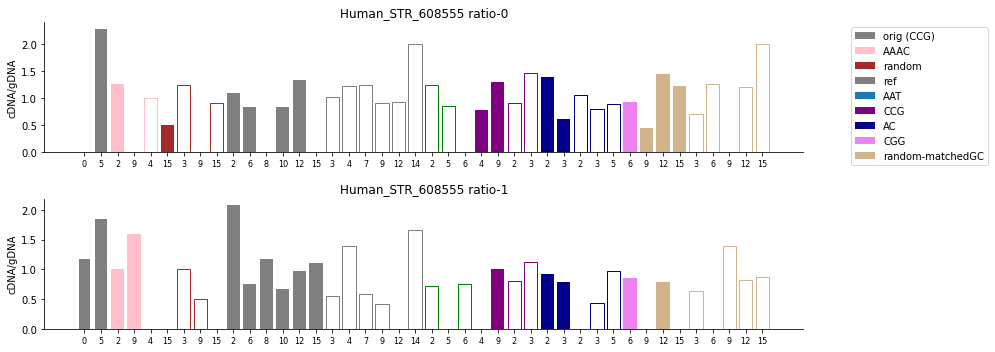

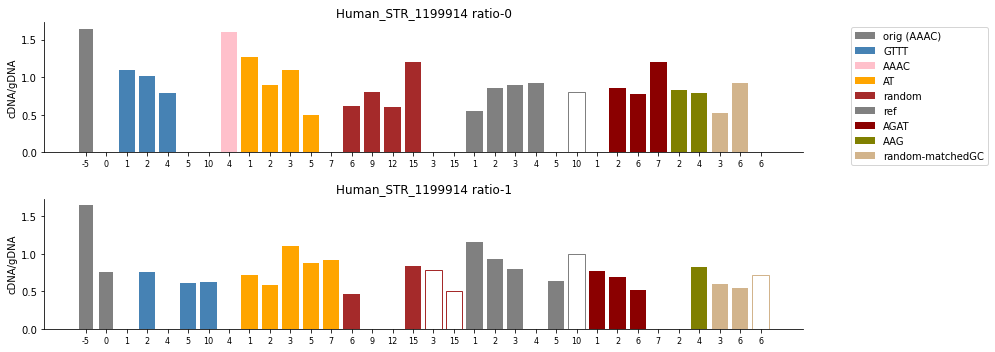

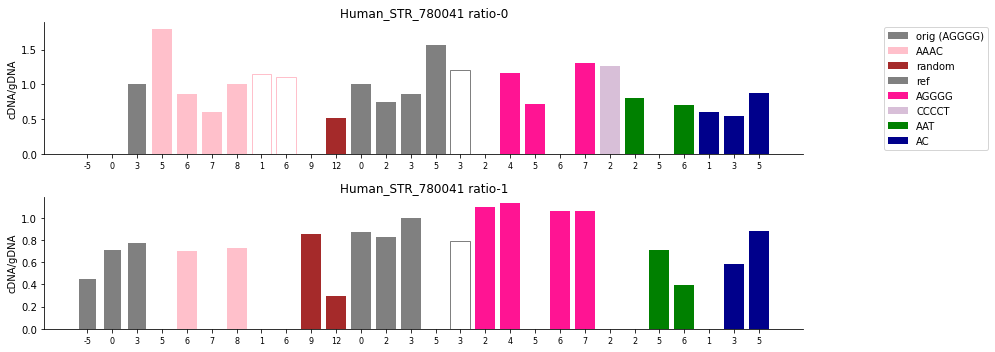

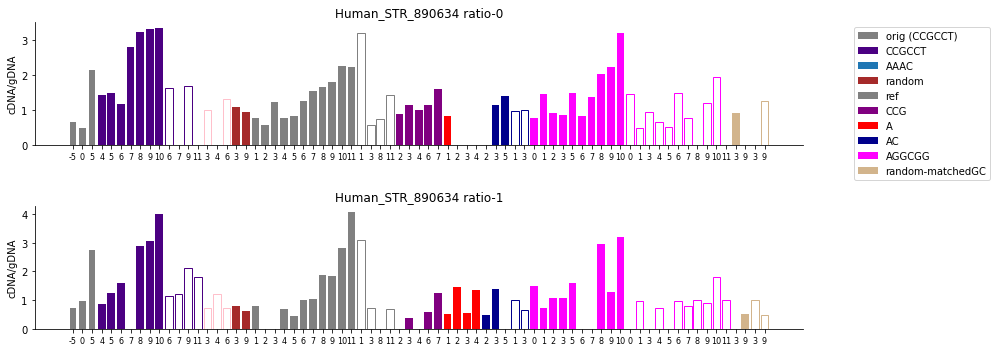

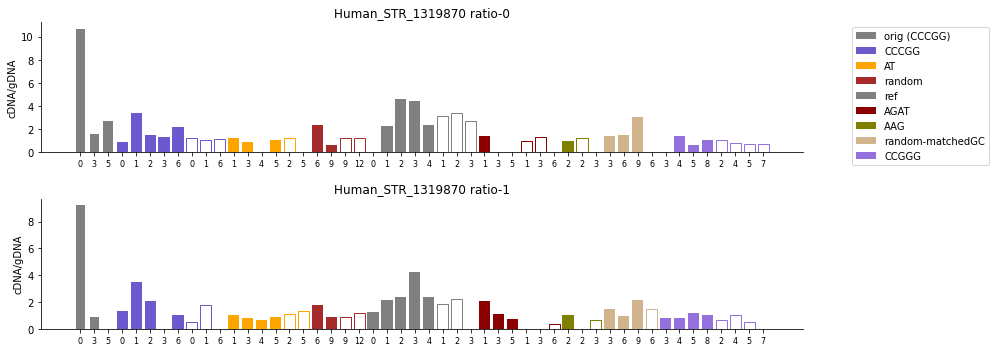

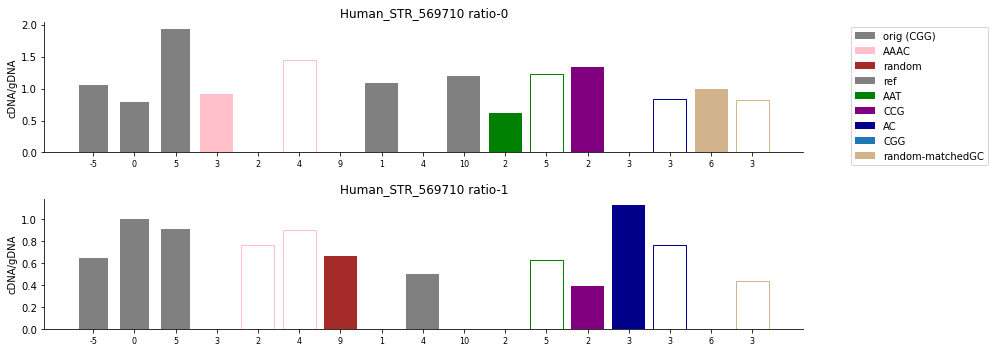

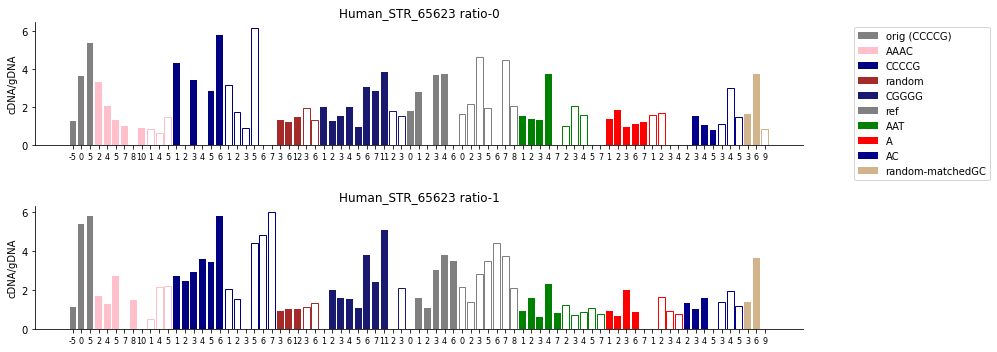

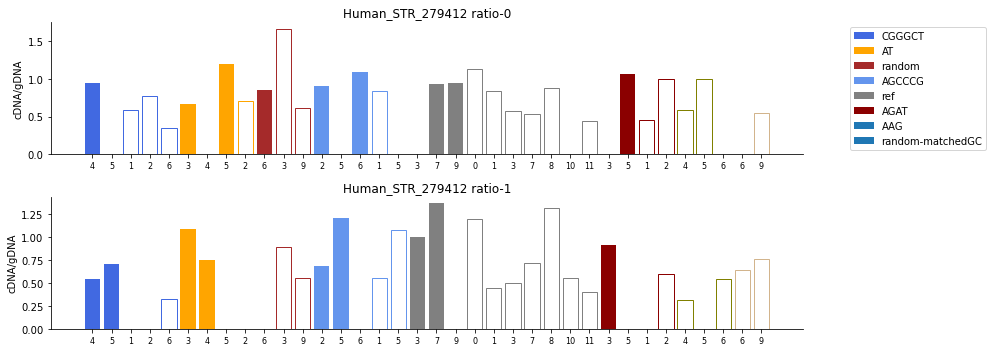

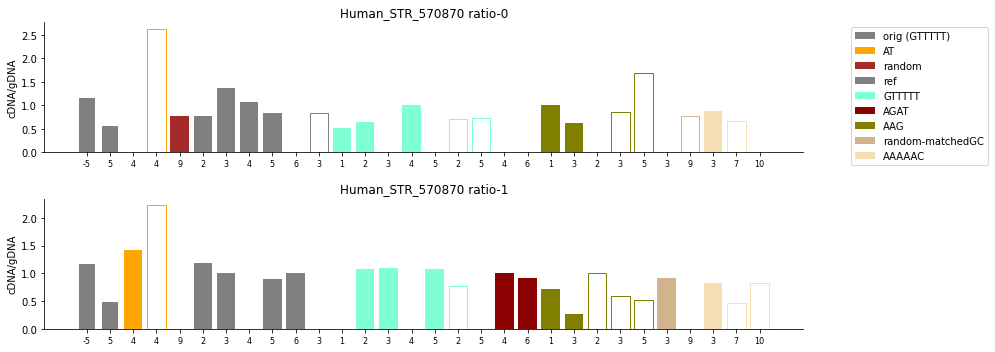

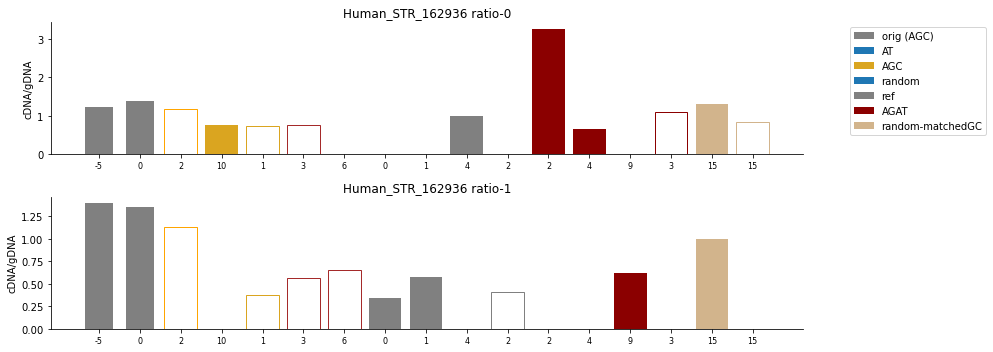

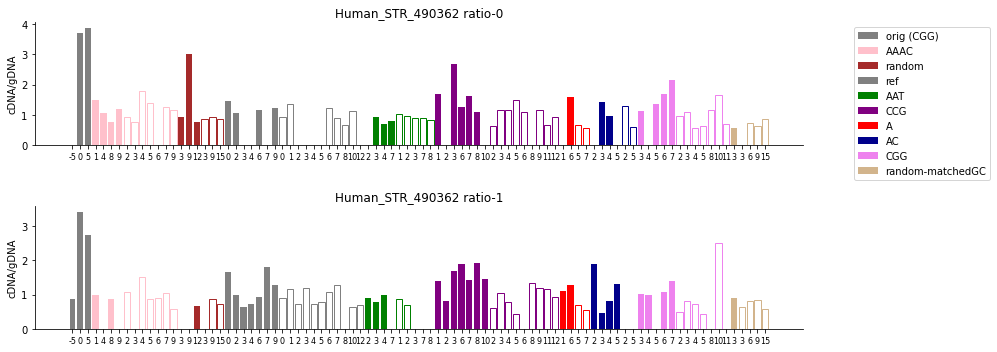

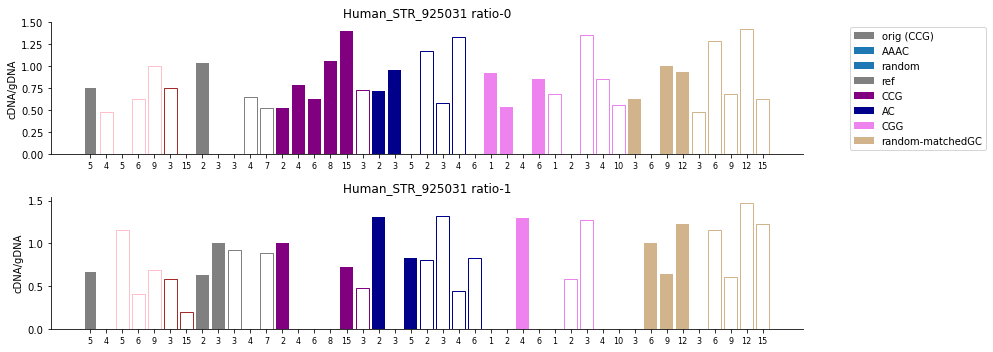

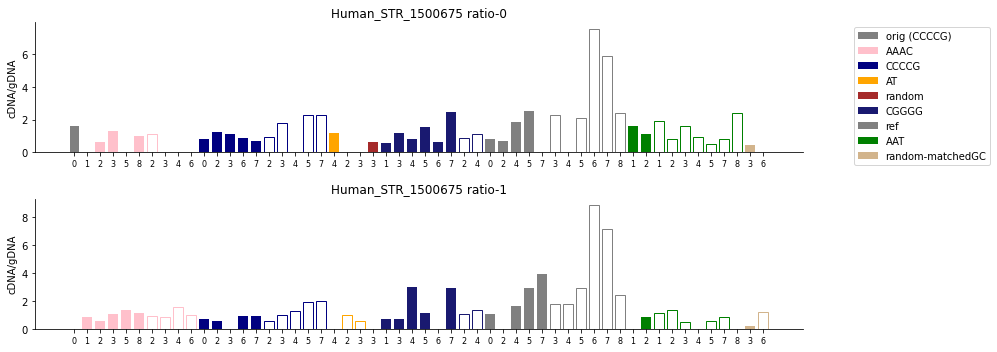

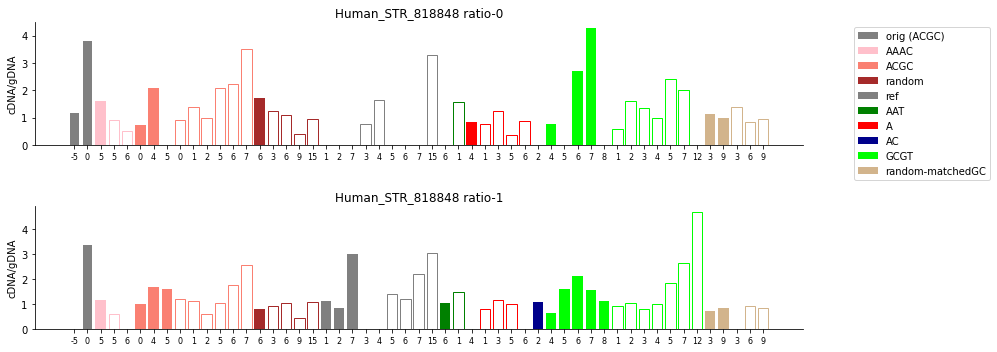

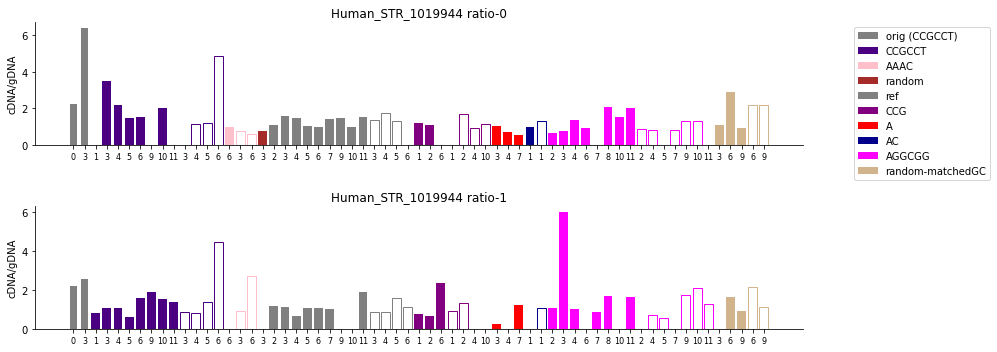

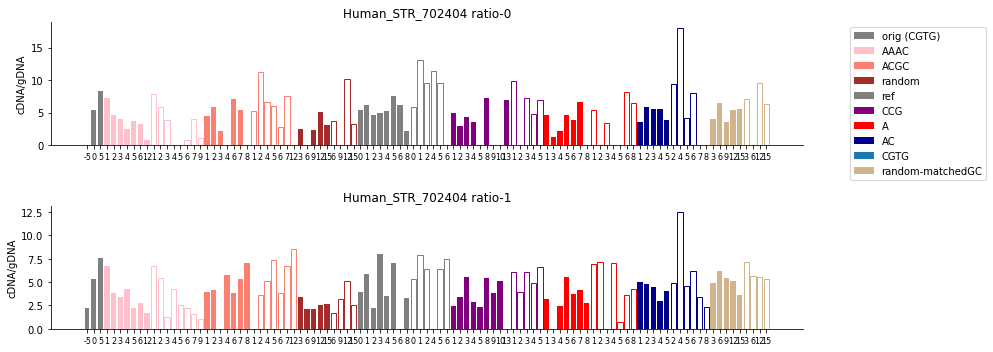

In [ ]:
strids = []
for df in count_dfs:
    strids.extend(list(df["STR"].apply(lambda x: "_".join(x.split("_")[0:3]), 1)))
allids = set(strids)
for strid in allids:
    print(strid)
    fname = "pngs/%s.png"%strid
    PlotUber(count_dfs, strid, fname=fname)